In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [2]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


# Load and Visualize

In [3]:
class VehicleDataset(Dataset):
    
    def __init__(self, path):
        data = np.load(path)
        self.images = data["images"]
        self.labels = data["labels"]
        print("Images shape:", self.images.shape)
        print("Labels shape:", self.labels.shape)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label

In [12]:
dataset = VehicleDataset('../dataset/stanford_cars_dataset.npz')

batch_size = 32
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = int(len(dataset) - train_size - val_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Images shape: (8144, 64, 64, 3)
Labels shape: (8144, 1)


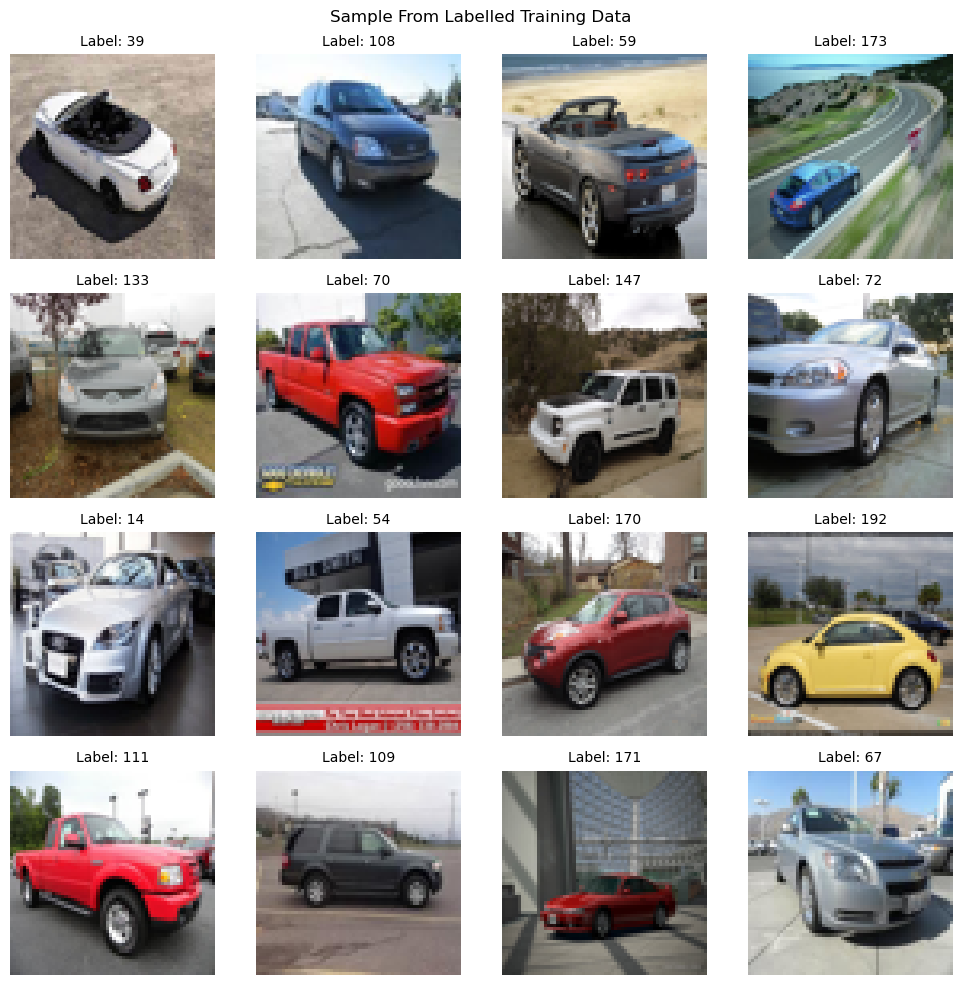

In [13]:
for images, labels in train_loader:
    break 

# Create figure
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for i in range(16):
    img = images[i].permute(1, 2, 0).numpy() 
    axes[i].imshow(img)
    axes[i].set_title(f"Label: {labels[i].item()}", fontsize=10)
    axes[i].axis("off")

plt.suptitle("Sample From Labelled Training Data")
plt.tight_layout(rect=[0, 0, 1, 1]) 
plt.show()

# LeNet-5
LeNet-5 implementation for 
- 64x64 input (vehicle image dataset)
- Binary Classification (vehicle or no vehicle)
- Modern ReLU Activation

In [14]:
class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)

        self.fc1 = nn.Linear(120*9*9, 84)
        self.fc2 = nn.Linear(84, 196)

        self.avgpool = nn.AvgPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.avgpool(self.relu(self.conv1(x)))
        x = self.avgpool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

# Training

In [15]:
lenet5 = LeNet5().to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet5.parameters(), lr=1e-3)

num_epochs = 20
for epoch in range(num_epochs):
    lenet5.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels[:,0].to(device) - 1

        # Forward
        outputs = lenet5(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")
    
    lenet5.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels[:,0].to(device) - 1
            
            outputs = lenet5(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    print(f'Validation Acc: {val_acc:.4f}')

Epoch 1/20 - Loss: 5.2812 - Accuracy: 0.0042
Validation Acc: 0.0025
Epoch 2/20 - Loss: 5.2732 - Accuracy: 0.0054
Validation Acc: 0.0061
Epoch 3/20 - Loss: 5.1865 - Accuracy: 0.0140
Validation Acc: 0.0086
Epoch 4/20 - Loss: 5.1272 - Accuracy: 0.0126
Validation Acc: 0.0104
Epoch 5/20 - Loss: 5.0987 - Accuracy: 0.0133
Validation Acc: 0.0104
Epoch 6/20 - Loss: 5.0674 - Accuracy: 0.0168
Validation Acc: 0.0092
Epoch 7/20 - Loss: 5.0240 - Accuracy: 0.0209
Validation Acc: 0.0141
Epoch 8/20 - Loss: 4.9603 - Accuracy: 0.0260
Validation Acc: 0.0141
Epoch 9/20 - Loss: 4.8892 - Accuracy: 0.0361
Validation Acc: 0.0184
Epoch 10/20 - Loss: 4.8030 - Accuracy: 0.0440
Validation Acc: 0.0184
Epoch 11/20 - Loss: 4.7025 - Accuracy: 0.0584
Validation Acc: 0.0178
Epoch 12/20 - Loss: 4.6028 - Accuracy: 0.0705
Validation Acc: 0.0178
Epoch 13/20 - Loss: 4.4772 - Accuracy: 0.0909
Validation Acc: 0.0154
Epoch 14/20 - Loss: 4.3516 - Accuracy: 0.1086
Validation Acc: 0.0172
Epoch 15/20 - Loss: 4.2207 - Accuracy: 0.13

# Testing

In [17]:
def test_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels[:,0].to(device) - 1 
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # Concatenate all predictions and labels if needed for further analysis
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    return accuracy, all_preds, all_labels

In [18]:
test_model(lenet5, test_loader, device)

Test Accuracy: 0.0172


(0.01715686274509804,
 tensor([105, 102,  64, 153,  58, 115, 166,  47,  70, 118,  98, 182, 193, 169,
          78, 150,  86,  57,  57,  73,  16,  43,  41, 118, 118,  68,  99,  51,
         131,  51, 135, 104, 128,  27, 136,  73, 161, 166,  46,  48,  61,  78,
         130,  83, 166,  69,  63, 188, 189, 179, 163, 136, 191, 166, 156, 136,
          76,  84, 173,  95,  90, 100,  25, 128,  73, 178, 124, 179, 181, 128,
         115, 166,  83,  59, 101, 157,  99, 163, 123, 175, 140,  43, 101,  78,
         188,  17, 153,   6,   7,   2, 188,  78, 136, 166,  65,  51,  69,  41,
          92, 176, 128, 189, 118, 148,  49,  74, 189,  73,  98,  97,  43,  69,
          41,  52, 153,  78, 110, 171,  51,  55,  65,  98, 118, 163, 166, 173,
          64, 165, 165, 106,  98,  53,  77, 166, 150,  25, 153,  69,  53, 167,
         166, 144,  78,  84,  15,  19, 148,  29,  44,  78,  53, 180,  88,  97,
           0,  19, 136,  83, 153,  69,  57,  37,  27,  69,  78,  31, 103,  40,
          45,  17, 104, 189, 1